# Part 1 ‑ Exploratory data analysis

<i>The attached </i>logins.json<i> file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

<b>Summary:</b> Logins show multiple periodic tendencies. There appears to be a weekly seasonality as well as a period approximately 12-hours in length. The weekly peaks occur on the weekends and the daily peaks appear to be around noon and near midnight. There is no obvious issue with data quality.

### Read and Process Data

The file 'logins.json' contains a single field `login_time`. We initially convert these to timestamps. 

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('../logins.json', convert_dates=True)

In [3]:
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


The goal is to count logins by 15 minute intervals. To do this, we'll initially convert `df` into a time series. The index will be login times and there will be a single feature `logins`. This will count the number of logins during a period, but for the initial time series conversion, we'll set `logins` equal to 1 in each row.

In [5]:
df = pd.DataFrame(data={'logins': 1}, index=df['login_time'])

In [6]:
df

,logins
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


Now that we have the time series set up, we resample in 15 minute intervals, summing the logins over these intervals.

In [7]:
df = df.resample('15T').sum()

In [8]:
df

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   logins  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


### Data Analysis

There are 9788 intervals in the data, with logins per interval ranging from a low of 0 to a maximum of 73. The median number of logins is 7 and the interquartile range is 10 (ranging from 3 to 13).

In [10]:
df.describe()

,logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Plotting the logins for each interval over time, some periodicity becomes evident. The plot is difficult to read because of the horizontal time interval, however it looks like there is a weekly seasonality coupled with a shorter-term period. This short-term seasonality could be daily.

In [11]:
import matplotlib.pyplot as plt

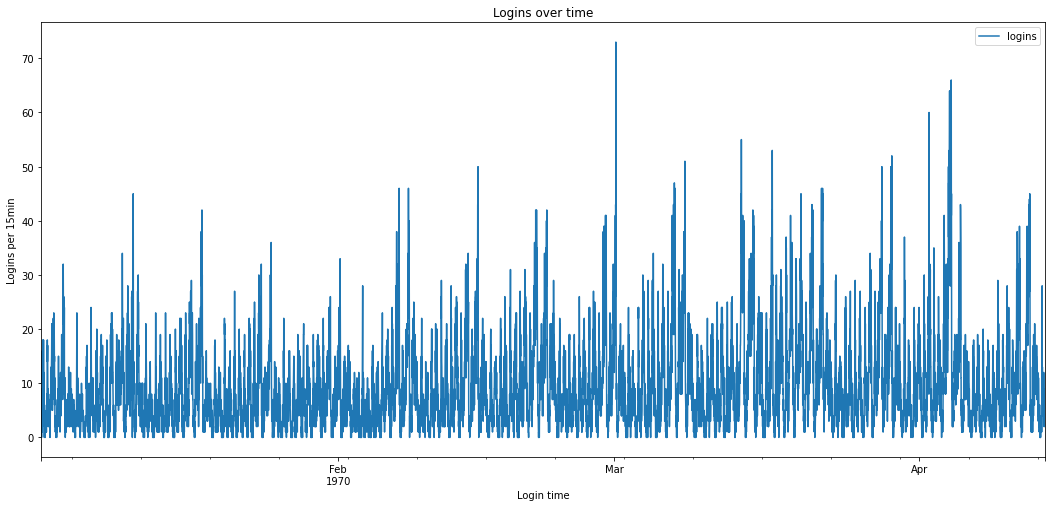

In [12]:
df.plot(figsize=(18,8), xlabel='Login time', ylabel='Logins per 15min', title='Logins over time');

Replotting for a single week makes it obvious that there we were correct about a short-term periodicity. It appears that it may be about 12 hours in length rather than daily.

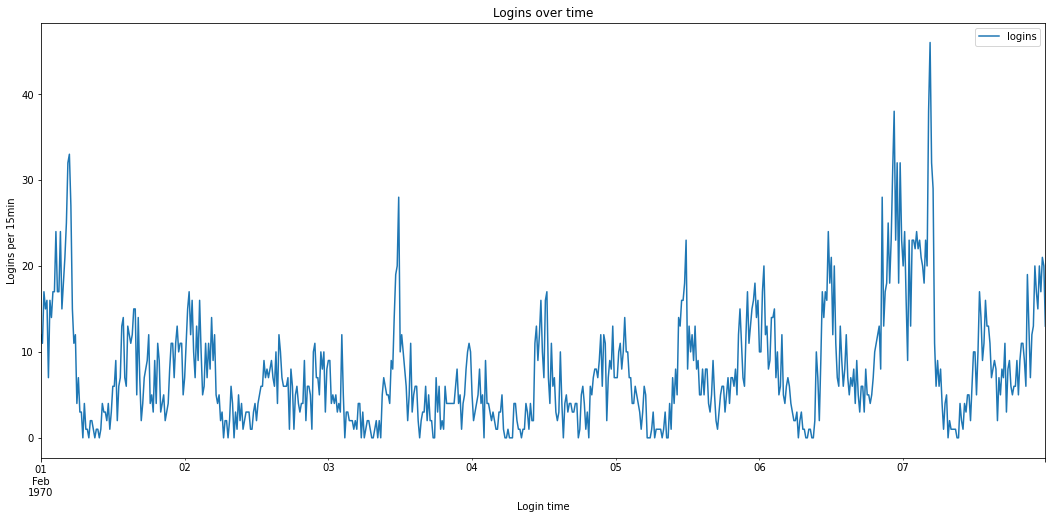

In [13]:
# Plot one week only.
df['1970-02-01':'1970-02-07'].plot(figsize=(18,8), xlabel='Login time', 
                                   ylabel='Logins per 15min', title='Logins over time');

Similarly, resampling shows that there is a longer-term periodicity, which appears to be compatible with a weekly period.

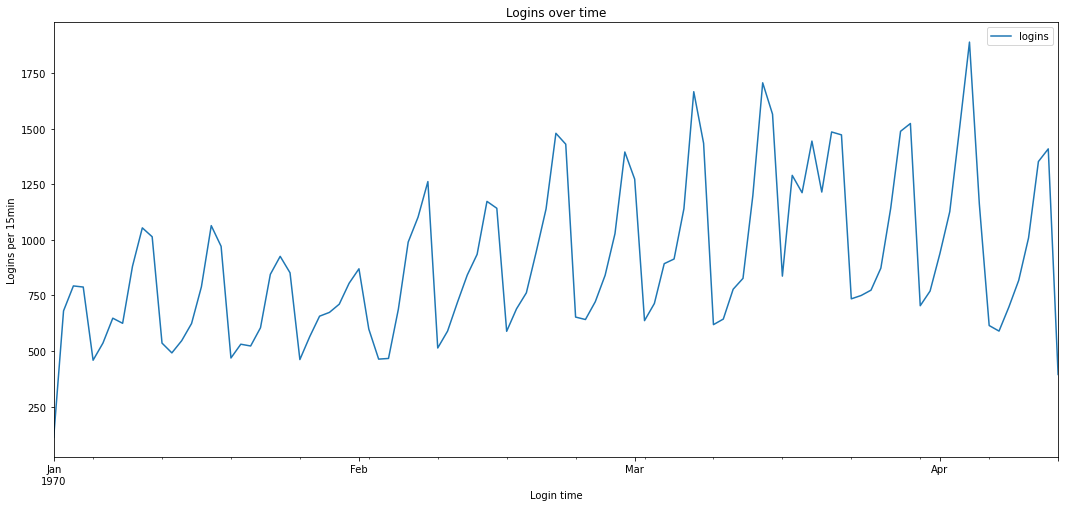

In [14]:
df.resample('1D').sum().plot(figsize=(18,8), xlabel='Login time', ylabel='Logins per 15min', title='Logins over time');

Plotting the auto-correlation function makes it clear that there are periodicities around 12 and 24 hours (48 and 96 periods).

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

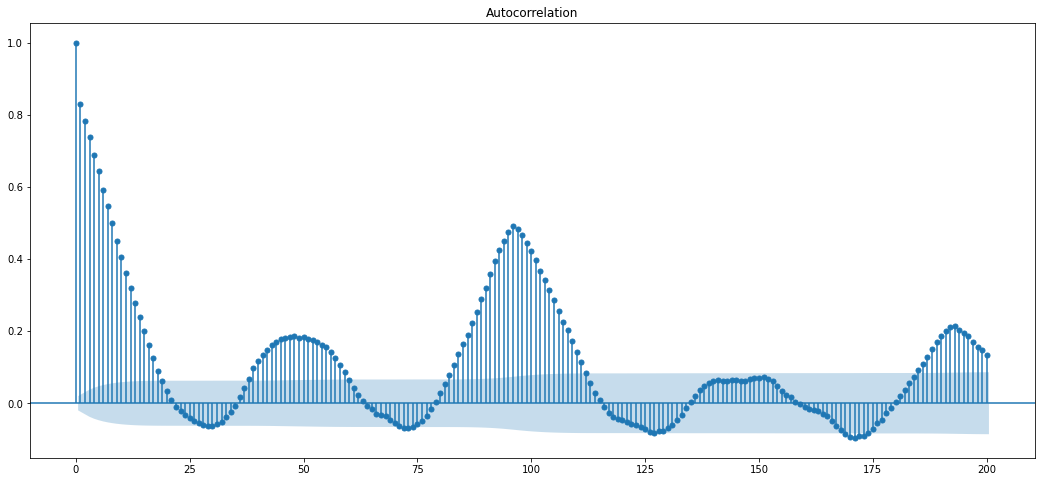

In [16]:
fig = plt.figure(figsize=(18,8));
ax = plt.axes()
plot_acf(df, ax=ax, fft=True, lags=200);

Resampling to one day intervals and then computing the auto-correlation function also verifies that weekly periodicity exists.

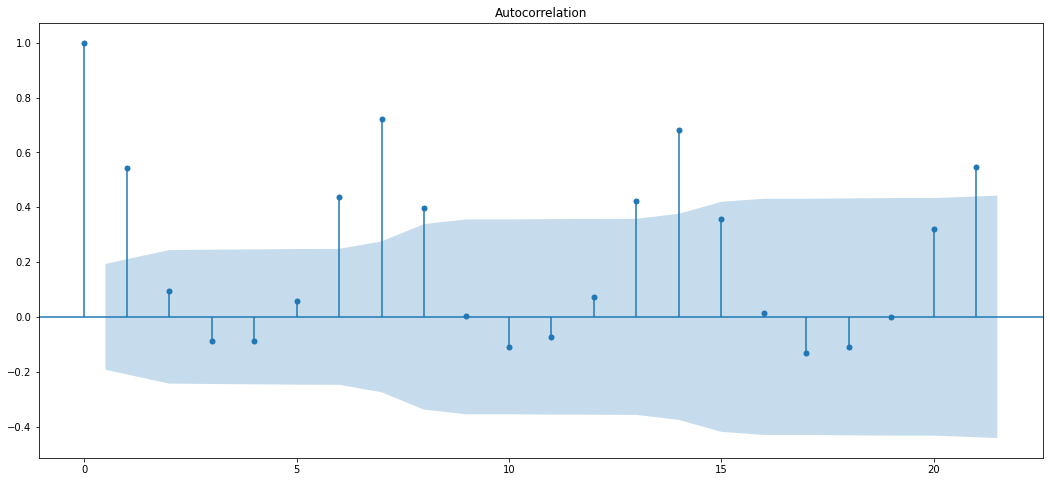

In [17]:
fig = plt.figure(figsize=(18,8));
ax = plt.axes()
plot_acf(df.resample('1D').sum(), ax=ax, fft=True);

Determine the days of week with the greatest number of logins.

In [18]:
daily_df = df.resample('1D').sum()
daily_df['day_of_week'] = daily_df.index.day_name()

In [19]:
daily_df

,logins,day_of_week
login_time,,
1970-01-01,112,Thursday
1970-01-02,681,Friday
1970-01-03,793,Saturday
1970-01-04,788,Sunday
1970-01-05,459,Monday
...,...,...
1970-04-09,818,Thursday
1970-04-10,1009,Friday
1970-04-11,1352,Saturday


There is a clear peak on the weekends, with Saturday and Sunday leading and Friday an obvious third.

In [20]:
daily_df
daily_df.groupby('day_of_week').mean()

,logins
day_of_week,
Friday,1013.866667
Monday,588.200000
Saturday,1291.800000
Sunday,1211.133333
Thursday,797.333333
Tuesday,662.000000
Wednesday,738.500000


Additionally, determine the times of day seeing the greatest number of logins.

In [21]:
df['time_of_day'] = df.index.time

In [22]:
df.groupby('time_of_day').mean().sort_values(by='logins')

,logins
time_of_day,
07:45:00,1.715686
08:15:00,1.754902
08:00:00,1.872549
07:30:00,1.882353
06:45:00,2.098039
...,...
22:00:00,16.019608
22:45:00,16.049020
22:15:00,16.196078


There are clear peaks late in the evening (within a couple hours of midnight) and right around noon. There is a sharp drop in the morning together with a lesser drop in the afternoon.

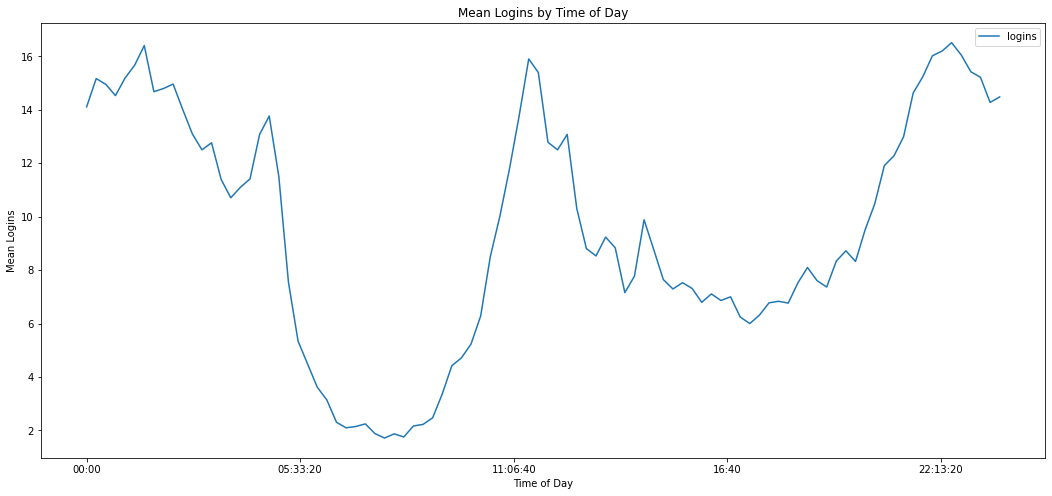

In [23]:
df.groupby('time_of_day').mean().plot(figsize=(18,8), title='Mean Logins by Time of Day', xlabel='Time of Day',
                                     ylabel='Mean Logins');

# Part 2 ‑ Experiment and metrics design

<i>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?</i>

<b>Answer:</b> We would hope to see an increase in the rate of driver partners serving both cities. This would indicate that proportionately more driver partners are willing to be available in both cities. This would be a better indicator than a strict count of driver partners serving both cities, as an underlying change in the total number of driving partners could lead to incorrect conclusions. In particular, an increase in the total number of drivers will likely naturally lead to an increase in drivers serving both cities, even if the proportion stays the same or equal. Likewise, if we were to see a decline in the total number of drivers, the number of drivers serving both cities would likely drop even if the proportion of drivers available in both stayed the same or increased.

<i>2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:</i>
    
<i>a. how you will implement the experiment</i>
    
<i>b. what statistical test(s) you will conduct to verify the significance of the observation</i>
    
<i>c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.</i>

<b>Answer:</b> <b>a.</b> Since there are multiple seasonalities in the ride data (daily and weekly), we would wish to compare the rate of drivers serving both cities over similar lengths of time covering the same number of cycles. The experiment would then set out a multi-week period to determine control counts. After the change is made, the counts should be repeated over a period of identical length. Both the control and experimental periods should begin (and end) at the same times on the same days of the week.

Since lack of independence in the experiment is likely to be an issue, it would be best to see if we can observe changes in the behavior of individual drivers. A number $2N$ of drivers should be chosen before the control period. Half of these drivers should be primarily active during the day, half at night. The idea is to try to roughly equalize participants from both cities without concerning ourselves with the overlap between those drivers who already serve both cities.

During the control period, these drivers should be tracked to see if they serve one city or both. The same will be repeated during the experimental period.

<b>b.</b> Due to lack of independence between the groups, a two-proportion $z$-test may not be valid. Instead, we can substitute a non-parametric test such as [McNemar's Test](https://en.wikipedia.org/wiki/McNemar%27s_test) to determine if there is a statistically significant different in the rate of drivers serving both cities. Tests should be done on all drivers and then potentially repeated while omitting drivers who didn't drive in one or both of the periods.

Bootstrapping can be used to estimate confidence intervals for the change in proportions.

<b>c.</b> The operations team should be given the effect size together with a confidence interval for the size. If the change is not statistically significant, the team should be informed that the results of the experiment are indistinguishable from chance.

Additionally, the proportions can be interpreted in monetary terms. The cost to the company of the program can be determined by using the proportion of drivers who served both cities in the experimental period. The change in revenue can be calculated from the change in proportions between the control and experimental periods. 

# Part 3 ‑ Predictive modeling

<i>Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file </i>ultimate_data_challenge.json<i>. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

<b>Summary:</b> <b>1.</b> Three features have missing data. As described below, two will be imputed with the feature mean and the remaining is a categorical variable that will be imputed with a specific new value.

The percentage of retained users from this sample was 36.620%.

The retention of users appears to be most closely correlated to city, trips in the first 30 days, the type of phone, and whether the user was an Ultimate Black user.

### Cleaning Data

In [24]:
df = pd.read_json('../ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])

In [25]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

We convert the boolean feature to integer values for use later.

In [27]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

Of the 50,000 users, we have complete data except for the two rating categories and for the phone category. There appear to be some differences between the users lacking ratings and those with ratings, however we will impute the mean rating in each category to the users.

For users without phone information, they may be signing up and requesting rides from a laptop or desktop PC. Lack of mobile options to request rides may potentially play a role in retention, so we will code that information as "missing".

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), in

In [29]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,0.37708,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,0.48466,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000


In [30]:
df[df.avg_rating_of_driver.isna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,8122.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8122.000000,8055.000000
mean,0.593327,NaN,1.078210,8.548067,0.336740,59.050948,7.506267,4.785984
std,0.606755,NaN,0.310306,26.578461,0.472624,46.859739,7.758616,0.622122
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,2.410000,5.000000
50%,1.000000,NaN,1.000000,0.000000,0.000000,100.000000,4.715000,5.000000
75%,1.000000,NaN,1.000000,0.000000,1.000000,100.000000,10.720000,5.000000
max,5.000000,NaN,5.000000,100.000000,1.000000,100.000000,160.960000,5.000000


In [31]:
df[df.avg_rating_of_driver.notna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41878.000000,41744.000000
mean,2.604972,4.601559,1.074095,8.908004,0.384904,61.289756,5.465290,4.776648
std,4.055311,0.617338,0.200861,18.401140,0.486578,34.858046,5.151833,0.404109
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.790000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,1.000000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,79.690000,5.000000


In [32]:
df[df.avg_rating_by_driver.isna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,201.000000,134.000000,201.000000,201.000000,201.000000,201.000000,201.000000,0.0
mean,0.552239,4.526119,1.165821,15.754726,0.169154,53.233831,6.167164,NaN
std,0.537129,0.930513,0.471684,36.370207,0.375824,50.019897,12.259533,NaN
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.980000,NaN
50%,1.000000,5.000000,1.000000,0.000000,0.000000,100.000000,3.360000,NaN
75%,1.000000,5.000000,1.000000,0.000000,0.000000,100.000000,6.370000,NaN
max,2.000000,5.000000,4.000000,100.000000,1.000000,100.000000,160.960000,NaN


In [33]:
df[df.avg_rating_by_driver.notna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,49799.000000,41744.000000,49799.000000,49799.000000,49799.000000,49799.000000,49799.000000,49799.000000
mean,2.285166,4.601801,1.074396,8.821665,0.377919,60.957132,5.795332,4.778158
std,3.798589,0.616079,0.220694,19.860920,0.484872,37.017558,5.665794,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,1.000000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,129.890000,5.000000


In [34]:
df[df.phone.isna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,396.000000,300.000000,396.000000,396.000000,396.000000,396.000000,396.000000,393.000000
mean,2.396465,4.614333,1.046338,5.620455,0.611111,66.218687,7.225859,4.815522
std,3.717477,0.612818,0.174052,15.404279,0.488115,36.140061,9.185866,0.382844
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,4.500000,1.000000,0.000000,0.000000,50.000000,2.857500,4.800000
50%,1.000000,4.900000,1.000000,0.000000,1.000000,74.150000,4.465000,5.000000
75%,2.000000,5.000000,1.000000,0.000000,1.000000,100.000000,8.652500,5.000000
max,27.000000,5.000000,3.000000,100.000000,1.000000,100.000000,129.890000,5.000000


In [35]:
df[df.phone.notna()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,49604.000000,41578.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49406.000000
mean,2.277256,4.601467,1.074991,8.875314,0.375212,60.883832,5.785418,4.777861
std,3.793300,0.617377,0.222666,19.989018,0.484182,37.086239,5.669709,0.447114
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,1.000000,100.000000,6.930000,5.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,160.960000,5.000000


### Imputation

We impute the "Missing" value in the phone column now. The other features will be imputed after the train-test split has been made so that the imputation uses only the mean of the training data.

In [36]:
df['phone'].fillna(value='Missing', inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), in

### Determination of Retained Users

All users in this table signed up in January 2014. The most recent trip taken by any user was July 1st, 2014. The definition of "retained" requires a user to have taken a trip in the last 30 days. For the purposes of this definition, we will consider the current date to be the same as the most recent trip seen.

In [38]:
print(f"Earliest signup date: {df.signup_date.min()}")
print(f"Latest signup date: {df.signup_date.max()}")
print(f"Latest trip date: {df.last_trip_date.max()}")

Earliest signup date: 2014-01-01 00:00:00
Latest signup date: 2014-01-31 00:00:00
Latest trip date: 2014-07-01 00:00:00


In [39]:
df['is_retained'] = df.last_trip_date > df.last_trip_date.max() - pd.Timedelta(value=30, unit='days')
df['is_retained'] = df['is_retained'].astype(int)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  is_retained             50000 non-null  int32 

We see that 36.620% of all users in this month were retained.

In [41]:
df.is_retained.describe()

count    50000.00000
mean         0.36620
std          0.48177
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: is_retained, dtype: float64

### Encoding Categorical Variables

In [42]:
import seaborn as sns

In [43]:
df = pd.concat(
        [df.drop('city',axis=1), pd.get_dummies(df['city'], prefix='city')],
         axis=1)
df = pd.concat(
        [df.drop('phone',axis=1), pd.get_dummies(df['phone'], prefix='phone')],
         axis=1)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  int32         
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    49799 non-null  float64       
 10  is_retained             50000 non-null  int32         
 11  city_Astapor            50000 non-null  uint8         
 12  city_King's Landing     50000 non-null  uint8 

Before continuing, we should eliminate the signup date and last trip date features. The signup date will not be useful to any models, since we're concerned with retention in the sixth month and all users in the table signed up in the same month. The last trip date fully determines the value of `is_retained`, so we should eliminate that feature or our models will focus on that relationship.

In [45]:
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    41878 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    49799 non-null  float64
 8   is_retained             50000 non-null  int32  
 9   city_Astapor            50000 non-null  uint8  
 10  city_King's Landing     50000 non-null  uint8  
 11  city_Winterfell         50000 non-null  uint8  
 12  phone_Android           50000 non-null  uint8  
 13  phone_Missing           50000 non-null  uint8  
 14  phone_iPhone            50000 non-null

### EDA

Looking at a correlation heatmap, it seems that retention is most correlated with trips in the first 30 days, whether the user is an Ultimate Black user, the city of origin, and the phone type.

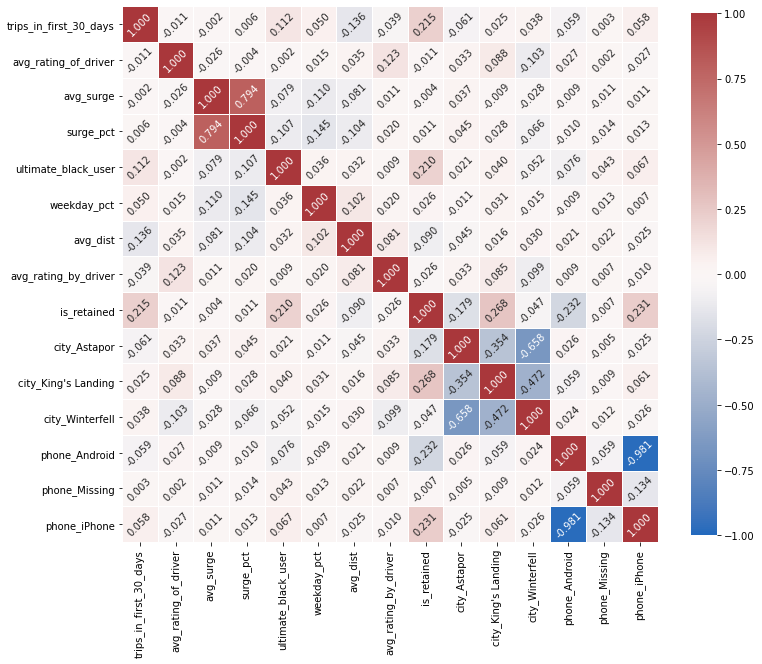

In [47]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, center=0, fmt='0.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={'rotation': 45});

Breaking the data down by whether the user was retained finds similar results. Trips in the first 30 days appear to be greater for retained users and more retained users are Ultimate Black users as well. More retained users come from King's Landing while more non-retained users come from Winterfell. Finally, more retained users signed up via iPhone while non-retained users appear more likely to have signed up via Android.

In the future, it seems appropriate to perform statistical tests to determine if the differences observed are significant.

In [48]:
df[df.is_retained==1].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Missing,phone_iPhone
count,18310.000000,16742.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18276.000000,18310.0,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000
mean,3.349590,4.593364,1.073720,9.128165,0.511141,62.214604,5.118977,4.763121,1.0,0.219661,0.344457,0.435882,0.160677,0.007100,0.832223
std,5.020615,0.538166,0.163183,15.489344,0.499890,29.068319,4.627946,0.324566,0.0,0.414029,0.475204,0.495885,0.367243,0.083964,0.373678
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,45.500000,2.560000,4.700000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,4.800000,1.000000,0.000000,1.000000,65.200000,3.730000,4.800000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.000000,5.000000,1.090000,13.300000,1.000000,85.700000,5.880000,5.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,125.000000,5.000000,4.500000,100.000000,1.000000,100.000000,160.960000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
df[df.is_retained==0].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Missing,phone_iPhone
count,31690.000000,25136.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31523.000000,31690.0,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000
mean,1.659167,4.607018,1.075367,8.688548,0.299621,60.181597,6.188478,4.786876,0.0,0.394825,0.120637,0.484538,0.381193,0.008394,0.610413
std,2.661903,0.664816,0.250219,22.132211,0.458099,40.985698,6.213027,0.503869,0.0,0.488821,0.325711,0.499769,0.485687,0.091234,0.487664
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.400000,1.000000,0.000000,0.000000,16.700000,2.320000,4.800000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,5.000000,1.000000,0.000000,0.000000,66.700000,4.030000,5.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,5.000000,1.000000,0.000000,1.000000,100.000000,7.770000,5.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,73.000000,5.000000,8.000000,100.000000,1.000000,100.000000,129.890000,5.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Summary:</b> <b>2.</b> There is some ambiguity corresponding to the definition of "retained" as it pertains to this part of the question. The question asks about retention in the sixth month. We will assume that the sixth month is the month of June for all users initially signing up in January. This allows us to use the `is_retained` field as calculated above.

We compare several classifier models (logistic regression, random forest, support vector classifier, histogram gradient boosting, ridge regression, naive Bayes, and K-nearest neighbor) on four metrics (accuracy, F1 score, precision, and recall). Histogram gradient boosting was chosen over the usual gradient boosting because of the size of the data set.

For each of the four metrics, we found that histogram gradient boosting provided the best performance. We selected that model to use for cross-validation hyperparameter tuning. A grid search led to small improvements.

We were able to get the accuracy near 0.8, but it may be possible to improve it further. An ensemble approach might be of assistance.

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = df.drop('is_retained', axis=1)
y = df['is_retained']
TEST_SIZE = 0.20
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [52]:
from sklearn import metrics

In [53]:
scores = {}
def score_classifier(name, y_true, y_pred):
    scores_acc = scores['acc'] if 'acc' in scores.keys() else {}
    scores_acc[name] = metrics.accuracy_score(y_true, y_pred)
    scores['acc'] = scores_acc
    
    scores_f1 = scores['f1'] if 'f1' in scores.keys() else {}
    scores_f1[name] = metrics.f1_score(y_true, y_pred)
    scores['f1'] = scores_f1
    
    scores_prec = scores['prec'] if 'prec' in scores.keys() else {}
    scores_prec[name] = metrics.precision_score(y_true, y_pred, zero_division=0)
    scores['prec'] = scores_prec
    
    scores_rec = scores['rec'] if 'rec' in scores.keys() else {}
    scores_rec[name] = metrics.recall_score(y_true, y_pred)
    scores['rec'] = scores_rec

In [54]:
def train_and_score_classifier(name, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_classifier(name, y_test, y_pred)

In [55]:
def print_classifier_scores(name):
    print(f'Accuracy: {scores["acc"][name]:0.4f}')
    print(f'F1: {scores["f1"][name]:0.4f}')
    print(f'Precision: {scores["prec"][name]:0.4f}')
    print(f'Recall: {scores["rec"][name]:0.4f}')

### Baseline Classifiers

In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

In [57]:
from sklearn.dummy import DummyClassifier

In [58]:
dummy_freq = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    DummyClassifier(strategy="most_frequent")
)

In [59]:
train_and_score_classifier('dummy_freq', dummy_freq)
print_classifier_scores('dummy_freq')

Accuracy: 0.6322
F1: 0.0000
Precision: 0.0000
Recall: 0.0000


In [60]:
dummy_strat = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
)

In [61]:
train_and_score_classifier('dummy_strat', dummy_strat)
print_classifier_scores('dummy_strat')

Accuracy: 0.5335
F1: 0.3550
Precision: 0.3612
Recall: 0.3491


### Logistic Regression Classifier

The vanilla logistic regression classifier outperforms both baselines on every metric.

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
lr = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    LogisticRegression()
)

In [64]:
train_and_score_classifier('lr', lr)
print_classifier_scores('lr')

Accuracy: 0.7211
F1: 0.5699
Precision: 0.6584
Recall: 0.5024


### Random Forest Classifier

The random forest presents an improvement on the logistic regression classifier.

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
rf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    RandomForestClassifier(random_state=RANDOM_STATE)
)

In [67]:
train_and_score_classifier('rf', rf)
print_classifier_scores('rf')

Accuracy: 0.7606
F1: 0.6697
Precision: 0.6798
Recall: 0.6599


### Support Vector Classifier

In [68]:
from sklearn.svm import LinearSVC

In [69]:
svc = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    LinearSVC(dual=False)
)

In [70]:
train_and_score_classifier('svc', svc)
print_classifier_scores('svc')

Accuracy: 0.7214
F1: 0.5603
Precision: 0.6678
Recall: 0.4826


### Gradient Boosting

Gradient boosting appears to be the best yet.

In [71]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [72]:
hgb = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    HistGradientBoostingClassifier(random_state=RANDOM_STATE)
)

In [73]:
train_and_score_classifier('hgb', hgb)
print_classifier_scores('hgb')

Accuracy: 0.7950
F1: 0.7097
Precision: 0.7405
Recall: 0.6813


### Ridge Regression

In [74]:
from sklearn.linear_model import RidgeClassifier

In [75]:
ridge = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    RidgeClassifier()
)

In [76]:
train_and_score_classifier('ridge', ridge)
print_classifier_scores('ridge')

Accuracy: 0.7205
F1: 0.5571
Precision: 0.6677
Recall: 0.4780


### Naive Bayes

In [77]:
from sklearn.naive_bayes import BernoulliNB

In [78]:
nb = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    BernoulliNB()
)

In [79]:
train_and_score_classifier('nb', nb)
print_classifier_scores('nb')

Accuracy: 0.7268
F1: 0.6224
Precision: 0.6329
Recall: 0.6123


### KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
knn = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    KNeighborsClassifier()
)

In [82]:
train_and_score_classifier('knn', knn)
print_classifier_scores('knn')

Accuracy: 0.7450
F1: 0.6434
Precision: 0.6624
Recall: 0.6253


### Model Choice

All four metrics indicate that HistGradientBoostingClassifier is the top-performing classifier.

In [83]:
metric_names = ['Accuracy', 'F1', 'Precision', 'Recall']
for i, metric in enumerate(['acc', 'f1', 'prec', 'rec']):
    print(f'Best {metric_names[i]}: {max(scores[metric], key=scores[metric].get)}')

Best Accuracy: hgb
Best F1: hgb
Best Precision: hgb
Best Recall: hgb


### Model Tuning

With cross-validation and a grid search, we can make marginal improvements.

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
param_grid = {
 'histgradientboostingclassifier__max_iter': [100, 500, 1000],
 'histgradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5],
 'histgradientboostingclassifier__max_depth' : [None, 25],
 'histgradientboostingclassifier__l2_regularization': [0, 1.5, 3],
 }
hgb_grid = GridSearchCV(hgb, param_grid, n_jobs=5, cv=5, verbose=3, refit=True)

In [86]:
%%time
hgb_grid.fit(X_train, y_train);

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Wall time: 2min 33s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingclassifier',
                                        HistGradientBoostingClassifier(random_state=42))]),
             n_jobs=5,
             param_grid={'histgradientboostingclassifier__l2_regularization': [0,
                                                                               1.5,
                                                                               3],
                         'histgradientboostingclassifier__learning_rate': [0.01,
                                                                           0.1,
                                                                           0.5],
                         'histgradientboostingclassifier__max_depth': [None,
                                                                       2

In [87]:
hgb_grid.best_params_

{'histgradientboostingclassifier__l2_regularization': 1.5,
 'histgradientboostingclassifier__learning_rate': 0.1,
 'histgradientboostingclassifier__max_depth': None,
 'histgradientboostingclassifier__max_iter': 500}

In [88]:
hgb_grid.best_score_

0.7950999999999999

In [89]:
hgb2 = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'), 
    StandardScaler(), 
    HistGradientBoostingClassifier(random_state=RANDOM_STATE,
                                  l2_regularization=1.5,
                                  learning_rate=0.1,
                                  max_depth=None,
                                  max_iter=500)
)

In [90]:
train_and_score_classifier('hgb2', hgb2)
print_classifier_scores('hgb2')

Accuracy: 0.7960
F1: 0.7108
Precision: 0.7426
Recall: 0.6816


<b>Summary: 3.</b> The model obtained in the last section could be used to validate the observations in the first section. In particular, two of the four features that had the largest correlation with retention are items that Ultimate could potentially influence. These are the number of rides in the first thirty days and whether the user is an Ultimate Black user. Further work should be done to determine if there is any causation between rides in the first thirty days and user retention. It could be the case that users who ride a lot in the first thirty days get hooked on the service. Conversely, it might be the case that users who will be retained are more likely to ride. Depending on results, it may be worthwhile for Ultimate to offer promotions for users in their first month. Additionally, Ultimate should promote Ultimate Black membership. The other two features (city and phone type) could allow Ultimate to focus advertising for new members.